In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import lda
import os
import pdb
import nltk
import string
import json
import random
import pickle
import pandas as pd
import seaborn as sns
import scipy

from IPython.display import clear_output
from os import makedirs
from os.path import join, exists
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

In [3]:
INPUT_DIR = join('tmp', 'parsed')
OUTPUT_DIR = join('tmp')
makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
np.random.seed(1234)

In [5]:
from nltk.stem.porter import PorterStemmer

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [193]:
import math

def intra_cluster_similarity(vectors):
    matx = scipy.sparse.vstack((vectors))
    return np.sum(cosine_similarity(matx, matx)) / math.pow(len(vectors), 2)

In [194]:
def intra_cluster_overall_similarity(vectors):
    similarity_topics = {}
    for k, values in vectors.items():
        if len(values) > 0:
            similarity_topics[k] = intra_cluster_similarity(values)

    return sum(similarity_topics.values()) / len(similarity_topics.values())

In [ ]:
def inter_cluster_overall_similarity(vectors):
    similarity_topics = {}
    for k, values in vectors.items():
        if len(values) > 0:
            matx = scipy.sparse.vstack((values))
            similarities = []
            for k2, values2 in vectors.items():
                if len(values) > 0 & k != k2:
                    matx2 = scipy.sparse.vstack((values2))
                    similarities.append(cosine_similarity(matx, matx2))
            similarity_topics[k] = np.average(similarities)

    return sum(similarity_topics.values()) / len(similarity_topics.values())

In [6]:
print("Building vocabulary...")

docs = {}
doc_tokens = {}
for fname in os.listdir(INPUT_DIR):
    if fname != '.DS_Store':
        with open(join(INPUT_DIR, fname), 'r') as f:
            doc = json.load(f)
            docs[doc['id']] = doc
            text = doc['body']
            table = str.maketrans({key: None for key in string.punctuation})
            text = text.lower().translate(table)
            doc_tokens[doc['id']] = text

token_keys = [x[0] for x in doc_tokens.items()]
token_values = [x[1] for x in doc_tokens.items()]
print(len(doc_tokens.items()))

Building vocabulary...
9086


# TF-IDF Vectorizer

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Processing TF-IDF")

vectorizer_tfidf = TfidfVectorizer(tokenizer=tokenize, norm='l2', stop_words='english')
X_tfidf = vectorizer_tfidf.fit_transform(token_values)

print(X_tfidf.shape)

Processing TF-IDF
(9086, 141273)


# Add Keywords to docs

In [954]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [955]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [976]:
for i, key in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    docs[key]['keywords'] = top_feats_in_doc(X_tfidf, vectorizer_tfidf.get_feature_names(), i, 50)
    
print(docs['2016-05-20-28']['keywords'])

       feature     tfidf
0         bull  0.337933
1       soccer  0.239934
2          red  0.209805
3         citi  0.193355
4      glidden  0.188261
5          nyc  0.183386
6           fc  0.167634
7       jersey  0.164249
8           ml  0.163835
9          fan  0.160802
10        team  0.159903
11        york  0.152018
12     stadium  0.148256
13       yanke  0.146709
14       city’  0.145608
15    ferrezza  0.141195
16         esc  0.135119
17     support  0.133098
18         new  0.128757
19       derbi  0.127820
20        club  0.111208
21      hudson  0.097068
22       river  0.089162
23     rivalri  0.088795
24           –  0.085512
25       giant  0.083519
26      derby’  0.078050
27        rail  0.076293
28       sport  0.069485
29      subway  0.066429
30        play  0.065766
31      yorker  0.064453
32       metro  0.060317
33    harrison  0.059349
34     inaugur  0.059196
35         say  0.059004
36  overshadow  0.058467
37   manhattan  0.057919
38     league’  0.057656


# Add Vector to docs

In [ ]:
for i, key in enumerate(token_keys):
    docs[key]['tfidf'] = X_tfidf[i]

docs['2016-05-20-28']['tfidf']

# Save & Load Docs

In [57]:
pickle.dump(docs, open('tmp/docs.pickle', 'wb'))

In [8]:
docs = pickle.load(open('tmp/docs.pickle', 'rb'))

docs['2016-05-20-28'].keys()

dict_keys(['authors', 'mod_topic', 'lda_matrix', 'lda', 'apiUrl', 'keywords', 'webTitle', 'tfidf', 'id', 'lda_value', 'webUrl', 'sectionId', 'body_t', 'body', 'guardianId', 'webPublicationDate', 'ents'])

# Build the graph from scratch

In [ ]:
g = ig.Graph()
for i, key in enumerate(token_keys):
    g.add_vertices(key)
    
print(g.vcount())

In [ ]:
g.delete_edges(g.es)
edges = []
for i, source in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    for j, target in enumerate(token_keys):
        edges.append((source, target))
            
g.add_edges(edges)  
edges = [] 
print(g.ecount())

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

count = 0
for i, source in enumerate(token_keys):
    similarities = cosine_similarity(X_tfidf[i], X_tfidf)[0]
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    for j, target in enumerate(token_keys):            
        g.es[count]["weight"] = similarities[j]
        count += 1

print(g.ecount())

Remove duplicated and self-loop edges

In [ ]:
g.simplify(multiple=True, loops=True, combine_edges="max")
print(g.ecount())

In [ ]:
g.es[1]['weight']

In [ ]:
g.write_gml('tmp/igraph.gml')

In [ ]:
g = ig.Graph.Read_GML('tmp/igraph.gml')

In [ ]:
sub_g = g.es.select(weight_ge=0.1).subgraph()

In [ ]:
print("Nodes {}".format(sub_g.vcount()))
print("Edges {}".format(sub_g.ecount()))

In [ ]:
print(sub_g.vs[1])
print(sub_g.vs[3])

In [ ]:
sub_g.write_gml('tmp/subgraph_01.gml')

# Load Network

In [10]:
g = ig.Graph.Read_GML('tmp/subgraph_01.gml')

In [13]:
def network_properties(g, community):
    print("Nodes {}".format(g.vcount()))
    print("Edges {}".format(g.ecount()))
    print("Diameter {}".format(g.diameter()))
    print("LCC {}".format(g.clusters().giant().vcount()))
    print("APL {}".format(g.average_path_length()))
    print("AD {}".format(sum(g.degree())/len(g.degree())))
    print("Giant Size {}".format(len(community.giant().vs())))
    print("NO of Communities {}".format(max(community.membership) + 1))
    print("Modularity {}".format(g.modularity(community.membership)))

In [14]:
threshold = np.average(cosine_similarity(X_tfidf))
threshold

0.032318418979897949

In [80]:
sg = g.es.select(weight_ge=0.1).subgraph()

In [81]:
# community = sg.community_infomap(edge_weights='weight')
# community = sg.community_multilevel(weights='weight')
community = sg.community_leading_eigenvector(weights='weight')
network_properties(sg, community)

Nodes 9048
Edges 708573
Diameter 7
LCC 9036
APL 2.638845668800883
AD 156.62533156498674
Giant Size 3243
NO of Communities 17
Modularity 0.4965933914218401


In [77]:
topics = {}

for i in range(max(community.membership) + 1):
    for v in community.subgraph(i).vs():
        topic_no = i
        try:
            topics[topic_no]
        except KeyError:
            topics[topic_no] = []

        topics[topic_no].append(docs[v['name']]['tfidf'])

In [74]:
print("Overall Similarity {}", intra_cluster_overall_similarity(topics))
print("Overall Similarity Top 10 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 10}))
print("Overall Similarity Top 30 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 30}))
print("Overall Similarity Top 100 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 100}))
print("Network Communities Modularity {}".format(sg.modularity(community.membership)))

Overall Similarity {} 1.0
Overall Similarity Top 10 {} 1.0
Overall Similarity Top 30 {} 1.0
Overall Similarity Top 100 {} 1.0
Network Communities Modularity 0.83984375


## Show contents of communities

In [21]:
with open('tmp/network_docs.txt', 'w+') as file:
    for i in range(max(community.membership) + 1):
        for v in community.subgraph(i).vs():
            file.write("Topic:{} File:{} Title:{}\n".format(i, v['name'], docs[v['name']]['webTitle']))

# Network Size Chart

In [39]:
def network_to_topics(com):
    topics = {}

    for i in range(max(com.membership) + 1):
        for v in com.subgraph(i).vs():
            topic_no = i
            try:
                topics[topic_no]
            except KeyError:
                topics[topic_no] = []

            topics[topic_no].append(v['name'])
    
    net_topics = {}
    count = 1
    for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
        net_topics[count] = value
        count += 1
        
    return net_topics

In [40]:
net_topics = network_to_topics(community)

In [53]:
for key, value in net_topics.items():
    for v in value:
        docs[v]['mod_topic'] = key

docs['2016-05-20-284'].keys()

dict_keys(['guardianId', 'lda_topic', 'keywords', 'webPublicationDate', 'ents', 'lda_matrix', 'webTitle', 'id', 'tfidf', 'webUrl', 'authors', 'body', 'sectionId', 'mod_topic', 'apiUrl', 'lda', 'lda_value', 'body_t'])

In [16]:
def community_to_size_chart(net_topics):
    x_data = []
    y_data = []
    for key, value in net_topics.items():
        x_data.append(key)
        y_data.append(len(value))

    ind = np.arange(0, len(y_data) * 2, 2)
    fig = plt.figure(figsize=(60,10))
    plt.bar(ind, y_data)
    plt.xticks(ind, x_data, rotation=90)
    plt.title("Topic Document Distribution")
    plt.xlabel("Topic")
    plt.ylabel("Frequency")
    fig.savefig('tmp/size_chart_net.png')
    plt.show()

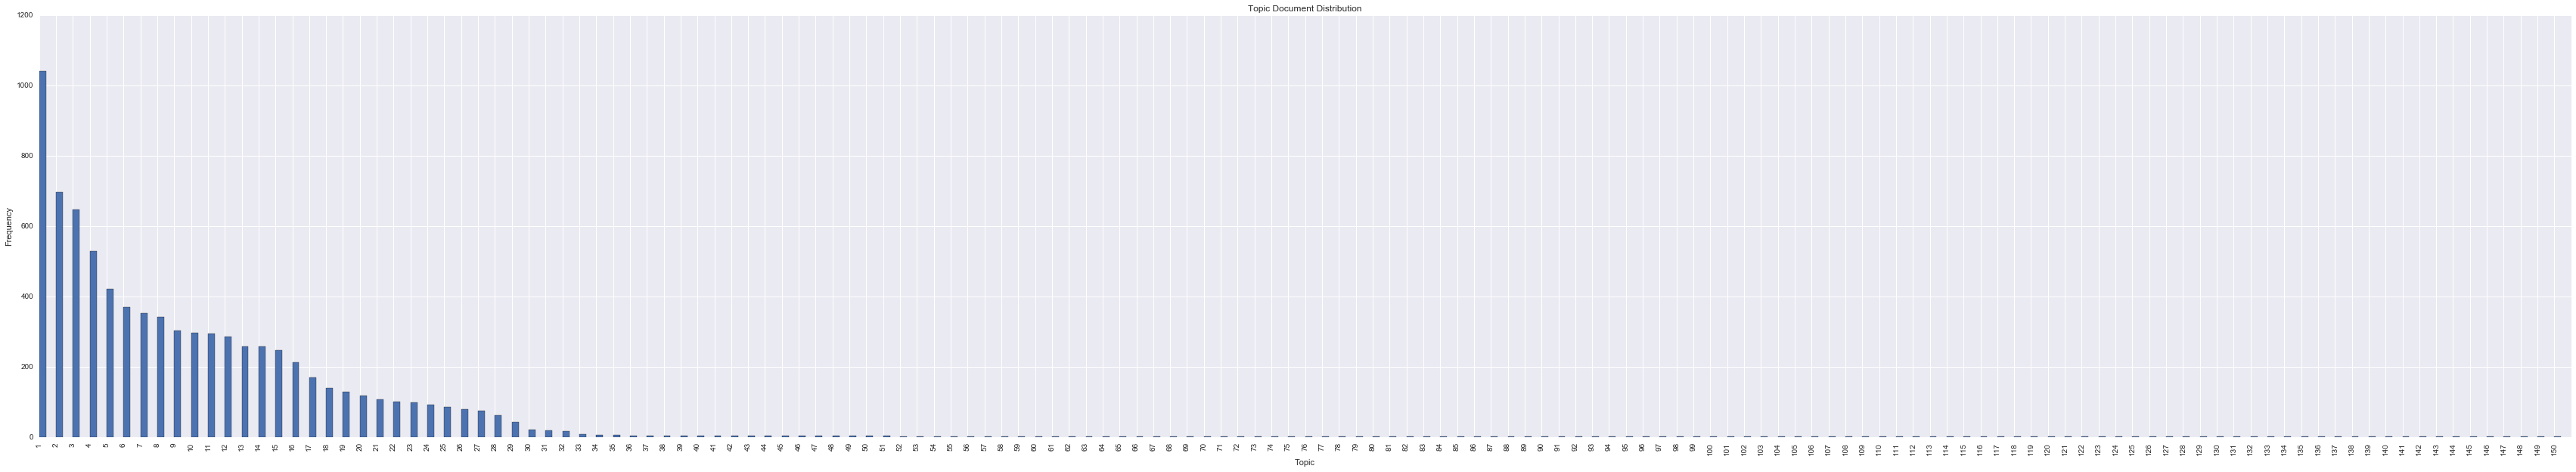

In [17]:
community_to_size_chart(net_topics)

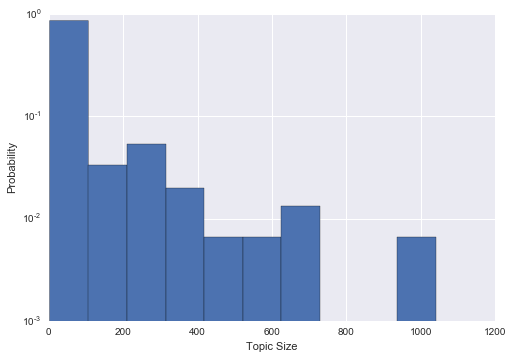

In [396]:
import scipy.stats as stats

def topics_to_prob_dist(topics):
    x_data = []
    y_data = []
    for key, value in topics.items():
        x_data.append(key)
        y_data.append(len(value))

    df = pd.DataFrame(y_data)
    # df.hist(weights=np.ones_like(df[df.columns[0]]*100.)/len(df))

    plt.hist(df, log=True, weights=np.ones_like(df[df.columns[0]]*100.)/len(df))
    plt.xlabel("Topic Size")
    plt.ylabel("Probability")
    
topics_to_prob_dist(net_topics)

# LDA

In [82]:
from gensim import matutils
from gensim.models.ldamodel import LdaModel

In [83]:
from sklearn.feature_extraction.text import CountVectorizer

print("Processing Count")

vectorizer = CountVectorizer(tokenizer=tokenize, stop_words='english')
X_count = vectorizer.fit_transform(token_values)

print(X_count.shape)

Processing Count
(9086, 141273)


In [84]:
vocab = vectorizer.get_feature_names()

In [172]:
def data_to_folds(data, k):
  folds = []

  for i in range(k):
    fold = []
    for j in range(i, data.shape[0], k):
      fold.append(data[j])
    folds.append(fold)

  return folds

folds = data_to_folds(X_count, 5)

In [173]:
# Partition data to train and test sets
# return list train data, list of test data
def split_folds(folds, i):
  train = folds[:i] + folds[i+1:]
  train = [x for data in train for x in data] # Flatten
  train = scipy.sparse.vstack((X_count_train))
  test = scipy.sparse.vstack(folds[i])
  
  return train, test

In [174]:
X_count_train.shape

(7268, 141273)

## Run LDA

In [182]:
np.random.seed(1234)

train_log_preps = []
test_log_preps = []
train_preps = []
test_preps = []

for i in range(len(folds)):
    print("Fold ", i)
    X_count_train, X_count_test = split_folds(folds, i)
    train_corpus = matutils.Sparse2Corpus(X_count_train.T)
    test_corpus = matutils.Sparse2Corpus(X_count_test.T)
    
    lda_model = LdaModel(train_corpus, 
                    num_topics=75,
                    passes=10,
                    id2word=dict([(i, s) for i, s in enumerate(vocab)]))
    
    train_log_prep_gensim = lda_model.log_perplexity(train_corpus)
    test_log_prep_gensim = lda_model.log_perplexity(test_corpus)
    train_preplexity_gensim = np.exp2(-train_log_prep_gensim)
    test_preplexity_gensim = np.exp2(-test_log_prep_gensim)
    
    train_log_preps.append(train_log_prep_gensim)
    test_log_preps.append(test_log_prep_gensim)
    train_preps.append(train_preplexity_gensim)
    test_preps.append(test_preplexity_gensim)

Fold  0
Fold  1
Fold  2
Fold  3
Fold  4


In [183]:
print(train_log_preps)
print(test_log_preps)
print(train_preps)
print(test_preps)

[-8.9106299093654791, -8.9098162732451858, -8.9047418496261095, -8.9032417212493122, -8.9098987997118773]
[-13.209182504215462, -10.867430794339647, -10.81480166913731, -10.896878313290888, -10.787577371961579]
[481.24572319251183, 480.97439176131553, 479.28562146342784, 478.78751461192962, 481.00190572046853]
[9470.2218290010333, 1868.1968905482852, 1801.2736649127221, 1906.7213583857463, 1767.6015328472072]


In [507]:
lda_model = LdaModel(matutils.Sparse2Corpus(X_count.T), 
                num_topics=10,
                passes=10,
                id2word=dict([(i, s) for i, s in enumerate(vocab)]))

In [508]:
pickle.dump(lda_model, open('tmp/gensim_lda_10_10.pickle', 'wb'))

## Load LDA

In [356]:
lda_model = pickle.load(open('tmp/gensim_lda_250_50.pickle', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'tmp/gensim_lda_50_10.pickle'

In [509]:
doc_topic_prob_mat = lda_model[matutils.Sparse2Corpus(X_count.T)]
print(len(doc_topic_prob_mat))

9086


In [510]:
for i, mat in enumerate(doc_topic_prob_mat):
    print('{0}\r'.format(i/len(doc_topic_prob_mat)))
    clear_output(wait=True)
    max_prob = max(mat, key=lambda x: x[1])
    docs[token_keys[i]]['lda'] = max_prob[0]
    docs[token_keys[i]]['lda_value'] = max_prob[1]

0.9998899405679067


In [511]:
pickle.dump(docs, open('tmp/docs_lda_10_10.pickle', 'wb'))

In [454]:
docs = pickle.load(open('tmp/docs_lda_250_50.pickle', 'rb'))

In [512]:
lda_items = sorted(docs.items(), key=lambda x: x[1]['lda'])

In [513]:
d = list(map(lambda x: x[1]['lda_value'], docs.items()))

In [514]:
d_avg = np.average(d)
d_avg

0.62621274093671186

In [515]:
sum(1 for x in d if x >= d_avg/2)

8842

In [403]:
with open('tmp/lda_docs.txt', 'w+') as file:
    for item in lda_items:
        file.write("Topic:{} File:{} Title:{}\n".format(item[1]['lda'], item[0], item[1]['webTitle']))

# LDA Size Chart

In [516]:
def lda_to_topics(lda_items):
    topics = {}

    for i in range(300):
        topics[i] = []

    for item in lda_items:
        topic_no = item[1]['lda']
        if item[1]['lda_value'] >= 0.0:
            topics[topic_no].append(item[0])

    lda_topics = {}
    count = 1
    for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
        lda_topics[count] = value
        count += 1
        
    return lda_topics

In [517]:
def lda_to_size_chart(lda_topics):
    print(len(lda_topics.keys()))

    x_data = []
    y_data = []
    for key, value in lda_topics.items():
        x_data.append(key)
        y_data.append(len(value))

    ind = np.arange(0, len(y_data) * 2, 2)
    fig = plt.figure(figsize=(60,10))
    plt.bar(ind, y_data)
    plt.xticks(ind, x_data, rotation=90)
    plt.title("LDA Topic Document Distribution")
    plt.xlabel("Topic")
    plt.ylabel("Frequency")
    fig.savefig('tmp/size_chart_lda.png')
    plt.show()

In [518]:
lda_items = sorted(docs.items(), key=lambda x: x[1]['lda'])
lda_topics = lda_to_topics(lda_items)

In [502]:
for key, value in lda_topics.items():
    for v in value:
        docs[v]['lda_topic'] = key

docs['2016-05-20-284'].keys()

dict_keys(['authors', 'lcm_topic', 'lda_topic', 'lda_matrix', 'lda', 'keywords', 'webTitle', 'tfidf', 'id', 'lda_value', 'webUrl', 'sectionId', 'body_t', 'apiUrl', 'guardianId', 'webPublicationDate', 'mod_topic', 'ents', 'body'])

50


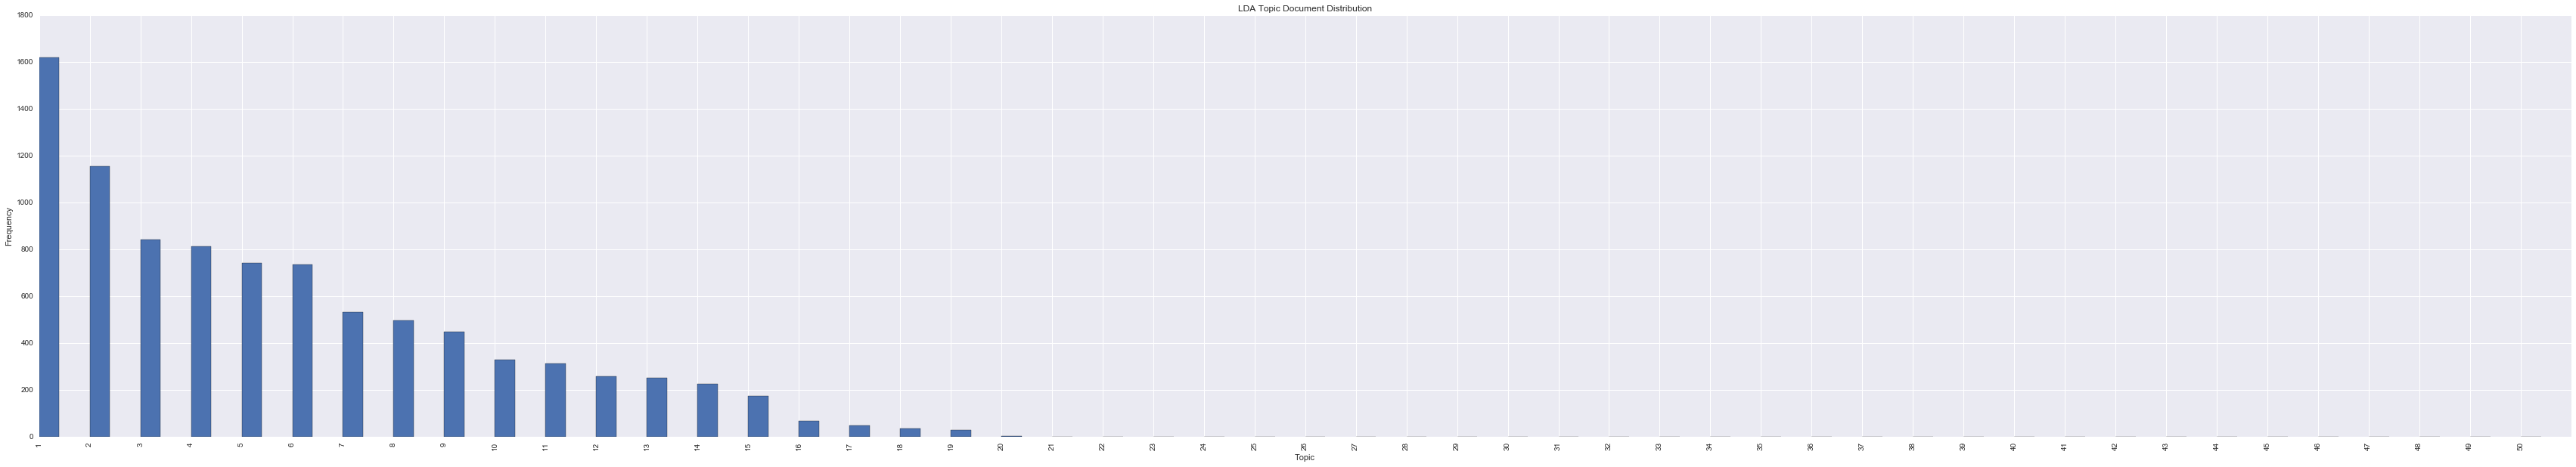

In [503]:
lda_to_size_chart(lda_topics)

In [504]:
topics_to_prob_dist(lda_topics)

NameError: name 'topics_to_prob_dist' is not defined

In [519]:
topics = {}

for k, vs in lda_topics.items():
    topics[k] = []
    for v in vs:
        topics[k].append(docs[v]['tfidf'])

intra_cluster_overall_similarity(topics)

0.056749728355305187

In [520]:
intra_cluster_similarity(topics[1])

0.033712558039718066

In [521]:
print("Overall Similarity Top 10", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 10}))
print("Overall Similarity Top 30", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 30}))
print("Overall Similarity Top 100", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 100}))

Overall Similarity Top 10 0.0567497283553
Overall Similarity Top 30 0.0567497283553
Overall Similarity Top 100 0.0567497283553


# Heatmap

In [116]:
def community_to_heatmap_data(network_topics):
    d = []
    for key, value in sorted(network_topics.items(), key=lambda x: x[0]):
        h = {}
        for v in value:
            h[v] = True
        d.append(h)

    return(d)

In [117]:
def lda_topics_to_heatmap_data(lda_topics):
    d = []
    for key, value in sorted(lda_topics.items(), key=lambda x: x[0]):
        h = {}
        for v in value:
            h[v] = True
        d.append(h)
        
    return d

In [118]:
net_data = community_to_heatmap_data(net_topics)
lcm_data = community_to_heatmap_data(lcm_topics)
lda_data = lda_topics_to_heatmap_data(lda_topics)

NameError: name 'lcm_topics' is not defined

In [987]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
vectors  = lda_data + net_data 
X_dict = vectorizer.fit_transform(vectors)

print(X_dict.shape)

(300, 8840)


In [988]:
print(len(lda_data[0].keys()))
print(len(net_data[0].keys()))
print(np.count_nonzero(X_dict[0].toarray()))

898
1041
1041


In [989]:
lda_vectors = X_dict[0:150]
net_vectors = X_dict[150:300]

In [990]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(lda_vectors, net_vectors)
similarities.shape

(150, 150)

In [991]:
pickle.dump(similarities, open('tmp/similarities_mod_lcm.pickle', 'wb'))

In [825]:
from sklearn.metrics.pairwise import cosine_similarity

filtered_sims = cosine_similarity(X_dict[0:30], X_dict[150:180])
filtered_sims.shape

(30, 30)

In [826]:
def filter_max_in_sims(sims):
    sims = sims.copy()
    for sim in sims:
        low_values_indices = sim < np.amax(sim)
        sim[low_values_indices] = 0 
    return sims

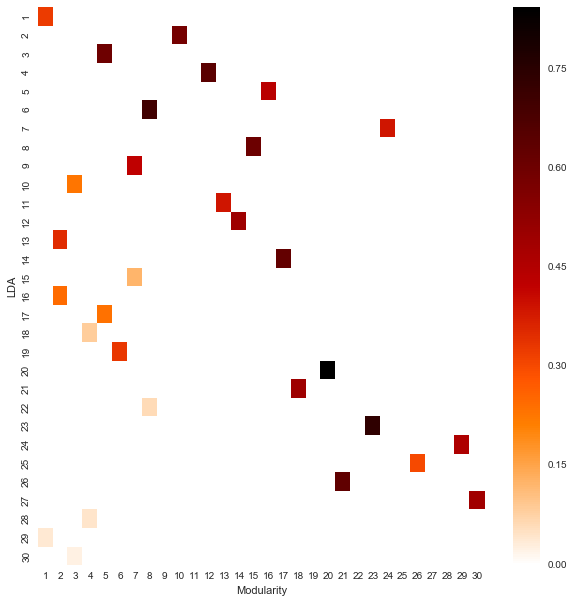

In [828]:
import seaborn as sns

filtered_sims = filter_max_in_sims(filtered_sims)
fig, ax = plt.subplots(figsize=(10, 10))
sns_plt = sns.heatmap(filtered_sims, cmap=plt.cm.gist_heat_r)
sns_plt.set(xticklabels=np.arange(1,31), yticklabels=(-np.sort(-np.arange(1,31))))
plt.xlabel("Modularity")
plt.ylabel("LDA")

# Size to topic table + keywords

In [977]:
import itertools

def keywords_to_keyword_table(topics, n):
    result = {}
    for topic in topics:
        items = list(map(lambda x: x.values.tolist(), topic[1]))
        keywords = sorted(list(itertools.chain(*items)), key=lambda x: x[1], reverse=True)
        keywords = list(map(lambda x: x[0], keywords))
        keywords2 = sorted(set(keywords),key=keywords.index)[:n]
        result[topic[0]] = (len(topic[1]), keywords2)
    return result

In [978]:
def topics_to_keywords(topics):
    results = {}

    for k, vs in topics.items():
        results[k] = []
        for v in vs:
            results[k].append(docs[v]['keywords'])

    results = sorted(results.items(), key=lambda x: len(x[1]), reverse=True)
    
    return results

In [979]:
lda_keywords = keywords_to_keyword_table(topics_to_keywords(lda_topics), 50)

In [980]:
net_keywords = keywords_to_keyword_table(topics_to_keywords(net_topics), 50)

In [981]:
lcm_keywords = keywords_to_keyword_table(topics_to_keywords(lcm_topics), 50)

In [982]:
set(lda_keywords[1][1]) & set(net_keywords[1][1])

{'antonia', 'cunk', 'eavi', 'hellboy', 'ipod', 'wed'}

In [942]:
import csv

sorted_1 = sorted(lda_keywords.items(), key=lambda x: x[1][0], reverse=True)
sorted_2 = sorted(net_keywords.items(), key=lambda x: x[1][0], reverse=True)
sorted_3 = sorted(lcm_keywords.items(), key=lambda x: x[1][0], reverse=True)

rows = []
for i in range(len(net_keywords)):
    row = [i+1]
    row += [sorted_1[i][1][0], sorted_2[i][1][0], sorted_3[i][1][0], sorted_1[i][1][1], sorted_2[i][1][1], sorted_3[i][1][1]]    
    rows.append(row)

with open('tmp/keywords.csv', 'w+') as file:    
    for row in rows:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(row)

In [992]:
similarities = pickle.load(open('tmp/similarities_mod_lcm.pickle', 'rb'))

In [993]:
a = similarities[6]
m = max(range(len(a)), key=lambda x: a[x])
m

23

In [994]:
import csv

rows = []
for i, row in enumerate(similarities):
    sim =  np.amax(row)
    net =  max(range(len(row)), key=lambda x: row[x]) + 1
    lda = i + 1
    rows.append([lda, net_keywords[lda][0], net, lcm_keywords[net][0], set(net_keywords[lda][1]) & set(lcm_keywords[net][1]), sim])

with open('tmp/matching.csv', 'w+') as file:    
    for row in sorted(rows, key=lambda x: x[1], reverse=True):
        writer = csv.writer(file, delimiter=';')
        writer.writerow(row)

# LCM

In [283]:
lda_model.minimum_probability=0.0

mat_lda = []
for i, m in enumerate(doc_topic_prob_mat):
    clear_output(wait=True)
    print('{0}\r'.format(i/len(token_keys)))
    a = []
    for n in m:
        if n[1] >= 0.01:
            a.append(n[1])
        else:
            a.append(0)
    mat_lda.append(a)

0.9998899405679067


In [284]:
mat_lda = np.mat(mat_lda)
pickle.dump(mat_lda, open('tmp/mat.pickle', 'wb'))
mat_lda[1]

matrix([[ 0.        ,  0.11856003,  0.        ,  0.        ,  0.        ,
          0.02403184,  0.10266708,  0.        ,  0.03900642,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.02798356,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.0366805 ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.11155131,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.01927168,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.02307031,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.01359342,  0.        ,  0.        ,  0.01692062,
          0.        ,  0.        ,  0.

## Add LDA to docs

In [285]:
for i, key in enumerate(token_keys):
    docs[key]['lda_matrix'] = scipy.sparse.csr_matrix(mat_lda[i])
  
docs['2016-05-20-28']['lda_matrix']

<1x150 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [286]:
g_lcm = ig.Graph()
for i, key in enumerate(token_keys):
    g_lcm.add_vertices(key)
    
print(g_lcm.vcount())

9086


In [287]:
g_lcm.delete_edges(g.es)
edges = []
for i, source in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    for i_2, target in enumerate(token_keys):
        edges.append((source, target))
    clear_output(wait=True)
            
g_lcm.add_edges(edges)  
edges = [] 
print(g_lcm.ecount())

82555396


In [295]:
from sklearn.metrics.pairwise import cosine_similarity

count = 0
for i, source in enumerate(token_keys):
    clear_output(wait=True)
    similarities = cosine_similarity(mat_lda[i], mat_lda)[0]
    print('{0}\r'.format(i/len(token_keys)))
    for j, target in enumerate(token_keys):  
        g_lcm.es[count]["weight"] = similarities[j]
        count += 1

print(g_lcm.ecount())

0.9998899405679067
82555396


In [296]:
g_lcm.simplify(multiple=True, loops=True, combine_edges="max")
print(g_lcm.ecount())

41273155


In [303]:
sg_lcm = g_lcm.es.select(weight_ge=0.1).subgraph()

In [304]:
print("Nodes {}".format(sg_lcm.vcount()))
print("Edges {}".format(sg_lcm.ecount()))

Nodes 9086
Edges 23508092


In [124]:
sg_lcm.write_gml('tmp/igraph_lcm_8245.gml')

## Load LCM Network

In [ ]:
lda_sim = cosine_similarity(mat_lda, mat_lda)

In [18]:
g_lcm = ig.Graph.Read_GML('tmp/igraph_lcm_8245.gml')

In [27]:
sg_lcm = g_lcm.es.select(weight_ge=0.8245).subgraph() #0.8245

In [28]:
print("Nodes {}".format(sg_lcm.vcount()))
print("Edges {}".format(sg_lcm.ecount()))

Nodes 7762
Edges 191303


In [29]:
# community = sg.community_infomap(edge_weights='weight')
community_lcm = sg_lcm.community_multilevel(weights='weight')
# community = sg.community_leading_eigenvector(weights='weight')

In [30]:
network_properties(sg_lcm, community_lcm)

Nodes 7762
Edges 191303
Diameter 19
LCC 7354
APL 6.189421671083362
AD 49.292192733831484
Giant Size 823
NO of Communities 150
Modularity 0.8262817233778451


In [54]:
lcm_topics = network_to_topics(community_lcm)

In [55]:
for key, value in lcm_topics.items():
    for v in value:
        docs[v]['lcm_topic'] = key

docs['2016-05-20-284'].keys()

dict_keys(['guardianId', 'lcm_topic', 'lda_topic', 'keywords', 'webPublicationDate', 'ents', 'lda_matrix', 'webTitle', 'id', 'tfidf', 'webUrl', 'authors', 'body', 'sectionId', 'mod_topic', 'apiUrl', 'lda', 'lda_value', 'body_t'])

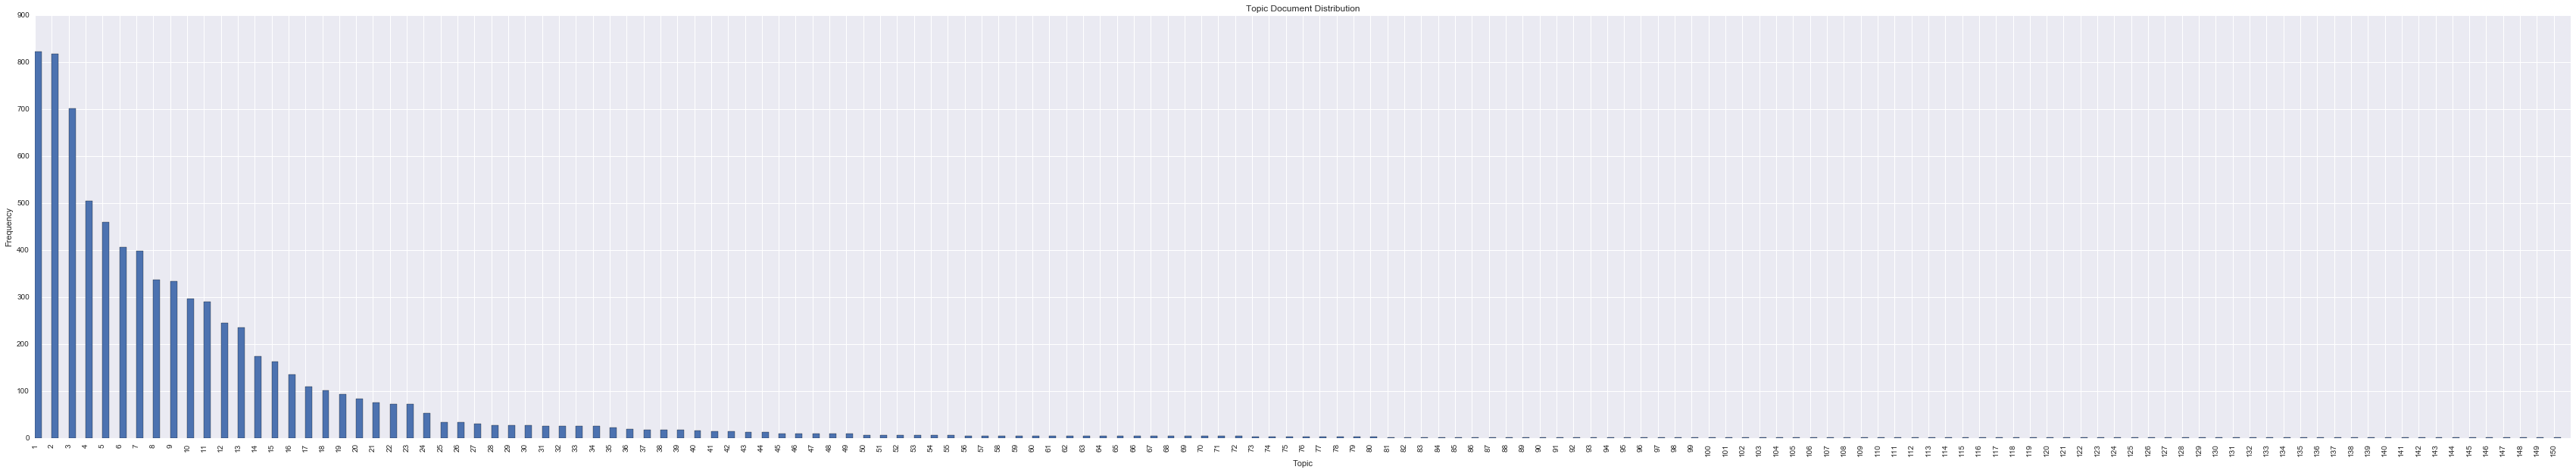

In [56]:
community_to_size_chart(lcm_topics)

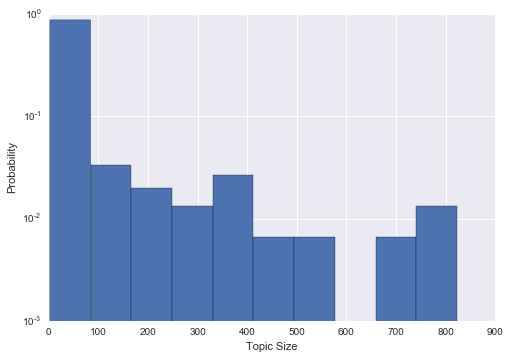

In [394]:
topics_to_prob_dist(lcm_topics)

In [ ]:
with open('tmp/lcm_docs.txt', 'w+') as file:
    for i in range(max(community_lda.membership) + 1):
        for v in community_lda.subgraph(i).vs():
            file.write("Topic:{} File:{} Title:{}\n".format(i, v['name'], docs[v['name']]['webTitle']))

## LDA network

In [273]:
g_lda = g_lcm.es.select(weight_ge=0.5).subgraph()
print("Nodes {}".format(g_lda.vcount()))
print("Edges {}".format(g_lda.ecount()))

Nodes 9086
Edges 2823445


In [274]:
lda_topics_values = [val for sublist in list(lda_topics.values()) for val in sublist]
len(lda_topics_values)

7452

In [275]:
to_delete_ids = [v.index for v in g_lda.vs if v['name'] not in lda_topics_values] 
len(to_delete_ids)

1634

In [276]:
g_lda.delete_vertices(to_delete_ids)
print("Nodes {}".format(g_lda.vcount()))
print("Edges {}".format(g_lda.ecount()))

Nodes 7452
Edges 1902342


In [334]:
sg_lda = g_lda.es.select(weight_ge=0.7).subgraph()
print("Nodes {}".format(sg_lda.vcount()))
print("Edges {}".format(sg_lda.ecount()))

Nodes 7406
Edges 610745


In [335]:
for v in sg_lda.vs:
    v['Community'] = docs[v['name']]['lda_sorted']
sg_lda.vs[0]

igraph.Vertex(<igraph.Graph object at 0x1188159a8>, 0, {'Community': 2, 'name': '2016-05-04-301', 'id': 0.0})

In [336]:
membership = []
for v in sg_lda.vs():
    membership.append(v['Community'])

In [337]:
print("LDA Communities Modularity {}".format(sg_lda.modularity(membership)))

LDA Communities Modularity 0.6869776895329


In [338]:
sg_lda.write_gml('tmp/igraph_lda_8.gml')

# Hierarchical Clustering

In [908]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [823]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(X_tfidf)

In [781]:
from sklearn.metrics.pairwise import euclidean_distances

dist = euclidean_distances(X_tfidf)

In [524]:
from scipy.cluster.hierarchy import ward, complete, average, dendrogram

In [782]:
print("Start Hierarchical Clustering...")

linkage_matrix = average(dist) #define the linkage_matrix using hierachical clustering pre-computed distances

print("Done Hierarchical Clustering...")

Start Hierarchical Clustering...
Done Hierarchical Clustering...


In [783]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(linkage_matrix, pdist(dist))
c

0.72507604694498762

In [824]:
pickle.dump(linkage_matrix, open('tmp/linkage_matrix_average_eucli.pickle', 'wb'))

In [913]:
linkage_matrix = pickle.load(open('tmp/linkage_matrix_average_eucli.pickle', 'rb'))

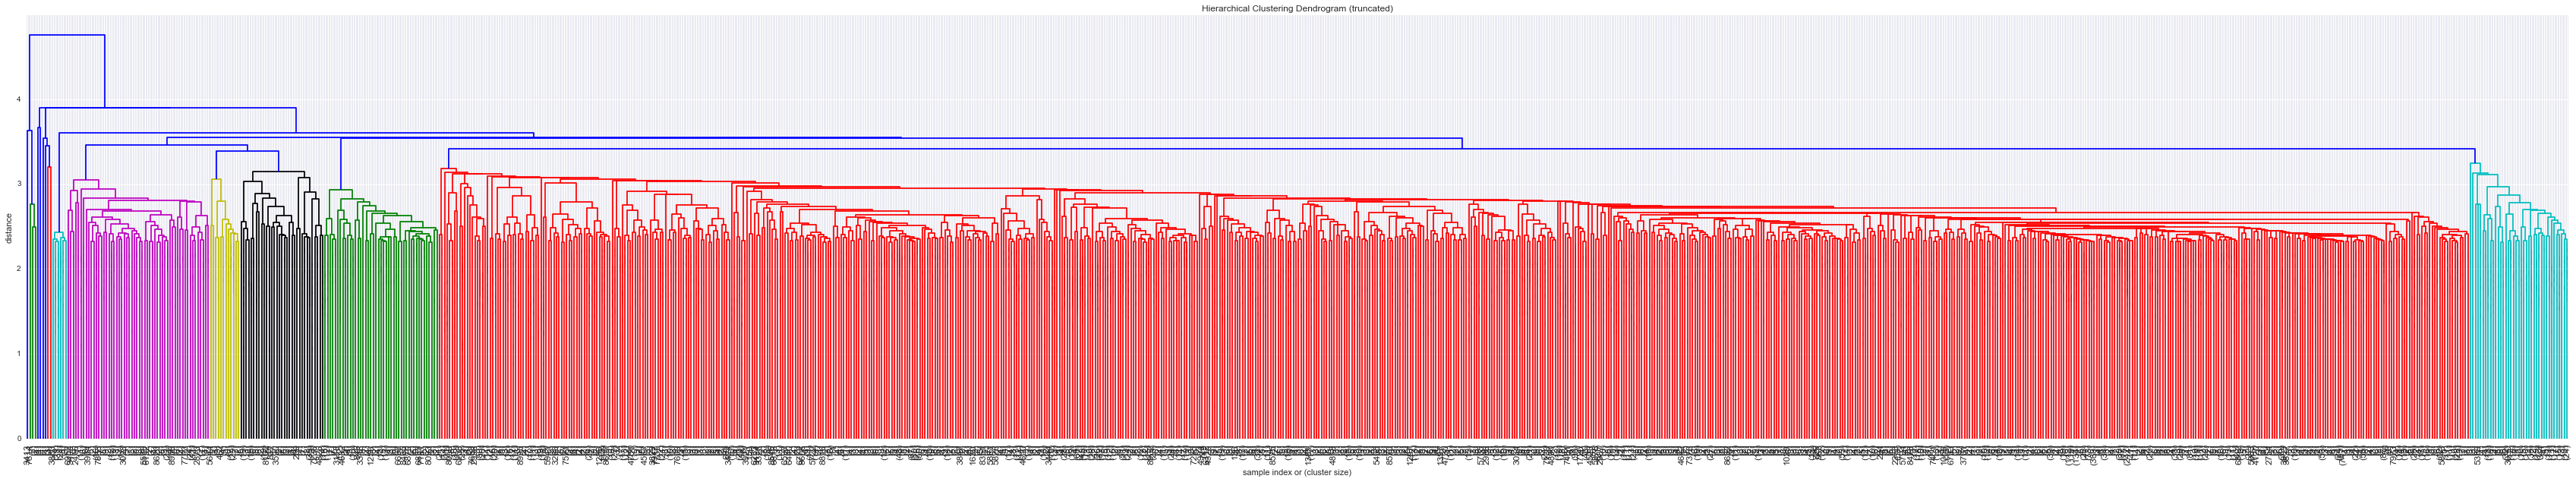

In [939]:
plt.figure(figsize=(60, 10))
fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=1000,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

In [947]:
from scipy.cluster.hierarchy import fclusterdata, fcluster

def cluster_indices(cluster_assignments):
    n = cluster_assignments.max()
    indices = []
    for cluster_number in range(1, n + 1):
        indices.append(np.where(cluster_assignments == cluster_number)[0])
    return indices

# Compute the clusters.
cluster_assignments = fcluster(linkage_matrix, 2.4, criterion="distance")

# Print the indices of the data points in each cluster.
num_clusters = cluster_assignments.max()
print("%d clusters" % num_clusters)
indices = cluster_indices(cluster_assignments)

print("Giant Size:", len(max(indices, key=lambda x: len(x))))

# for k, ind in enumerate(indices):
#     print("cluster", k + 1, " (Length:)", len(ind), "=", ind)

for k, ind in enumerate(indices):
    for i in ind:
        docs[token_keys[i]]['hclust'] = k

592 clusters
Giant Size: 1038


In [948]:
hclust_items = sorted(docs.items(), key=lambda x: x[1]['hclust'])

In [949]:
with open('tmp/hclust_docs.txt', 'w+') as file:
    for item in hclust_items:
        file.write("Topic:{} File:{} Title:{}\n".format(item[1]['hclust'], item[0], item[1]['webTitle']))

In [950]:
topics = {}

for i in range(num_clusters):
    topics[i] = []
    
for item in hclust_items:
    topic_no = item[1]['hclust']
    topics[topic_no].append(item[0])
    
print(len(topics.keys()))

hclust_topics = {}
count = 1
for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
    hclust_topics[count] = value
    count += 1

592


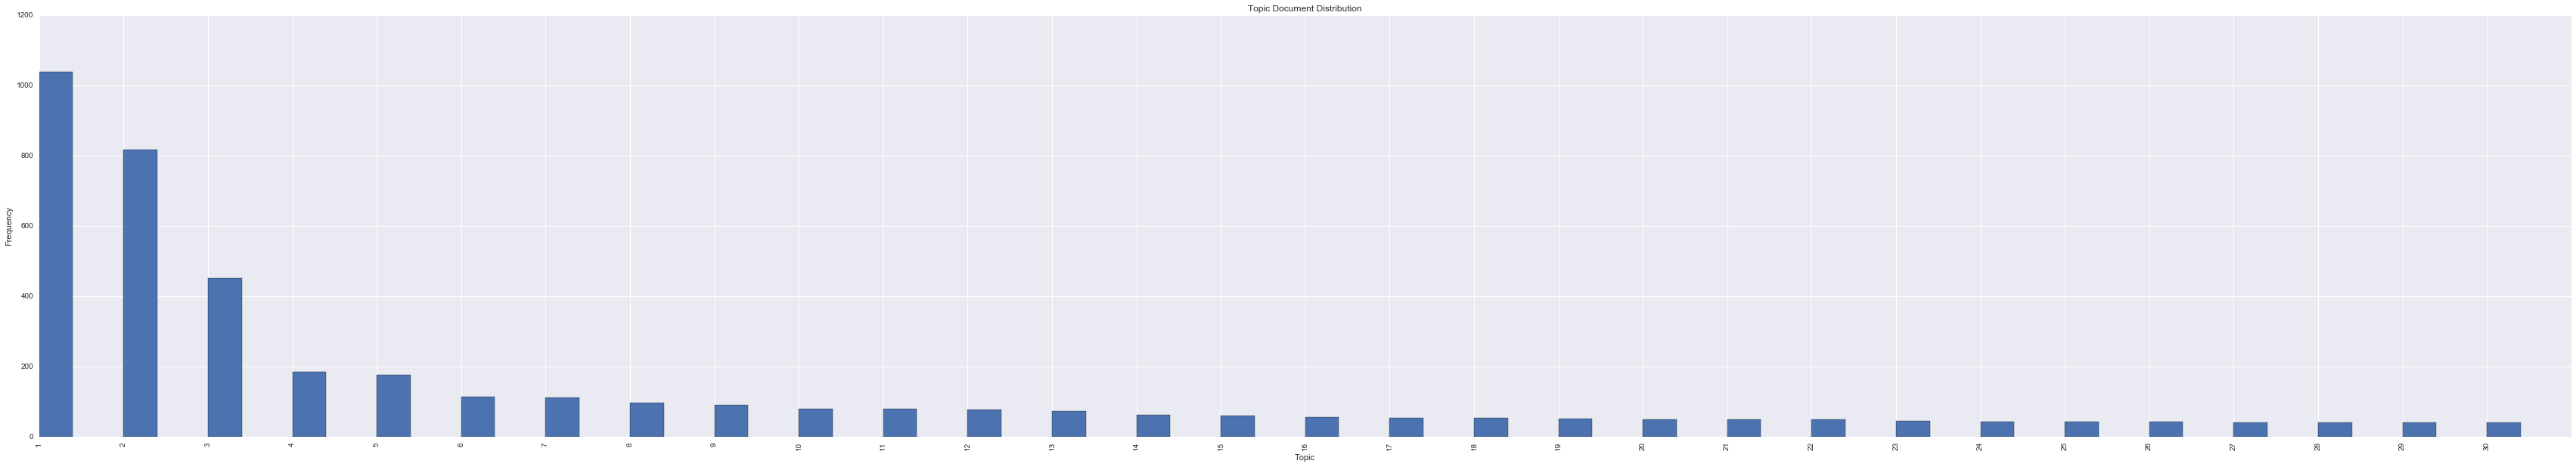

In [951]:
x_data = []
y_data = []
for key, value in sorted(hclust_topics.items(), key=lambda x: len(x[1]), reverse=True):
    if key <= 30:
        x_data.append(key)
        y_data.append(len(value))

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure(figsize=(60,10))
plt.bar(ind, y_data)
plt.xticks(ind, x_data, rotation=90)
plt.title("Topic Document Distribution")
plt.xlabel("Topic")
plt.ylabel("Frequency")
fig.savefig('tmp/size_chart_lda.png')
plt.show()

In [952]:
topics = {}

for k, vs in hclust_topics.items():
    topics[k] = []
    for v in vs:
        topics[k].append(docs[v]['tfidf'])

intra_cluster_overall_similarity(topics)

0.47456809810158856

In [953]:
print("Overall Similarity Top 10 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 10}))
print("Overall Similarity Top 30 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 30}))
print("Overall Similarity Top 100 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 100}))

Overall Similarity Top 10 {} 0.0662631311105
Overall Similarity Top 30 {} 0.151035928491
Overall Similarity Top 100 {} 0.229936954286


# KMeans

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 1200

km = KMeans(n_clusters=num_clusters)

%time km.fit(X_tfidf)

clusters = km.labels_.tolist()

In [68]:
pickle.dump(km, open('tmp/km.pickle', 'wb'))

In [764]:
km = pickle.load(open('tmp/km.pickle', 'rb'))

In [765]:
clusters = km.labels_.tolist()
clusters[0]

16

In [ ]:
for i, cluster in enumerate(clusters):
    print('{0}\r'.format(i/len(clusters)))
    clear_output(wait=True)
    docs[token_keys[i]]['km'] = cluster

In [767]:
def km_to_topics(km_items):
    topics = {}

    for i in range(300):
        topics[i] = []

    for item in km_items:
        topic_no = item[1]['km']
        topics[topic_no].append(item[0])

    km_topics = {}
    count = 1
    for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
        km_topics[count] = value
        count += 1

    return km_topics

In [768]:
km_items = sorted(docs.items(), key=lambda x: x[1]['km'])
km_topics = km_to_topics(km_items)

In [769]:
topics = {}

for k, vs in km_topics.items():
    topics[k] = []
    for v in vs:
        topics[k].append(docs[v]['tfidf'])

intra_cluster_overall_similarity(topics)

0.062456916980175615

In [770]:
print("Overall Similarity Top 10 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 10}))
print("Overall Similarity Top 30 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 30}))
print("Overall Similarity Top 100 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 100}))

Overall Similarity Top 10 {} 0.0365771067719
Overall Similarity Top 30 {} 0.0403154712968
Overall Similarity Top 100 {} 0.0500464647507


# Visualization

In [31]:
def add_community_to_graph(key, graph, com):
    for i in range(max(com.membership) + 1):
        for v in com.subgraph(i).vs():
            node = graph.vs().find(name=v['name'])
            node['Community'] = docs[v['name']][key]

## Modularity Network

In [386]:
topics = {}

for i in range(max(community.membership) + 1):
    for v in community.subgraph(i).vs():
        topic_no = i
        try:
            topics[topic_no]
        except KeyError:
            topics[topic_no] = []

        topics[topic_no].append(docs[v['name']]['tfidf'])

In [387]:
print("Overall Similarity {}", intra_cluster_overall_similarity(topics))
print("Overall Similarity Top 10 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 10}))
print("Overall Similarity Top 30 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 30}))
print("Overall Similarity Top 100 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 100}))
print("Network Communities Modularity {}".format(sg.modularity(community.membership)))

Overall Similarity {} 0.733234501023
Overall Similarity Top 10 {} 0.826339933173
Overall Similarity Top 30 {} 0.824217456112
Overall Similarity Top 100 {} 0.732469515204
Network Communities Modularity 0.7770162025166544


In [36]:
# topic = topics[2]
# print(np.dot((topic[0] + topic[1]).toarray() / len(topic), (topic[0] + topic[1]).toarray().T / len(topic)))

intra_cluster_similarity(topics[1])

0.59947680876274956

In [38]:
sg.write_gml('tmp/network_community.gml')

## LDA

In [390]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(lda_vectors, net_vectors)

matching = {}
for i, a in enumerate(similarities):
    b =  max(range(len(a)), key=lambda x: a[x])
    matching[i] = b

print(matching)

{0: 0, 1: 8, 2: 4, 3: 10, 4: 14, 5: 13, 6: 32, 7: 17, 8: 26, 9: 1, 10: 18, 11: 39, 12: 22, 13: 21, 14: 36, 15: 20, 16: 42, 17: 25, 18: 6, 19: 29, 20: 23, 21: 11, 22: 30, 23: 1, 24: 23, 25: 31, 26: 40, 27: 0, 28: 11, 29: 9, 30: 39, 31: 15, 32: 0, 33: 2, 34: 3, 35: 0, 36: 20, 37: 3, 38: 20, 39: 0, 40: 0, 41: 0, 42: 9, 43: 25, 44: 24, 45: 0, 46: 3, 47: 3, 48: 0, 49: 0}


In [ ]:
for v in sg_lda.vs:
    v['Community'] = docs[v['name']]['lda_sorted']
sg_lda.vs[0]

In [ ]:
membership = []
for v in sg_lda.vs():
    membership.append(v['Community'])

In [ ]:
print("LDA Communities Modularity {}".format(sg_lda.modularity(membership)))

In [ ]:
for v in sg_lda.vs:
    v['Community'] = matching[v['Community']]

In [ ]:
sg_lda.vs[0]

In [ ]:
sg_lda.write_gml('tmp/lda_community.gml')

In [189]:
topics = {}

for k, vs in lda_topics.items():
    topics[k] = []
    for v in vs:
        topics[k].append(docs[v]['tfidf'])

intra_cluster_overall_similarity(topics)

0.31506991178271709

In [412]:
intra_cluster_similarity(topics[1])

0.060205147720234477

In [191]:
print("Overall Similarity Top 10", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 10}))
print("Overall Similarity Top 30", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 30}))
print("Overall Similarity Top 100", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 100}))

Overall Similarity Top 10 0.0822215088418
Overall Similarity Top 30 0.111106386257
Overall Similarity Top 100 0.209335295193


## LCM

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

similarities = cosine_similarity(lda_vectors, net_vectors)

matching = {}
matching_count = {}
matching_count = defaultdict(lambda: 0, matching_count)

for i, a in enumerate(similarities):
    b =  max(range(len(a)), key=lambda x: a[x])
    if b in matching.values():
        matching_count[b] += 0.1
        matching[i] = b + matching_count[b]
    else:
        matching[i] = b

print(matching)

In [60]:
for v in sg_lcm.vs:
    v['Community'] = docs[v['name']]['lcm_topic']

In [62]:
sg_lcm.write_gml('tmp/lcm_community.gml')

In [65]:
topics = {}

for k, vs in lcm_topics.items():
    topics[k] = []
    for v in vs:
        topics[k].append(docs[v]['tfidf'])

intra_cluster_overall_similarity(topics)

0.48598567957221644

In [66]:
print("Overall Similarity Top 10 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 10}))
print("Overall Similarity Top 30 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 30}))
print("Overall Similarity Top 100 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 100}))

Overall Similarity Top 10 {} 0.0769973535112
Overall Similarity Top 30 {} 0.131370115617
Overall Similarity Top 100 {} 0.390543830857
